In [333]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
import emcee
import corner

from astropy.timeseries import BoxLeastSquares
import astropy.units as u

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

**Problem 1:** Compute formula for the overlap area of two circles as a function
of their separation, b, and radius ratio, $k=R_p/R_*$.

**Problem 2:** Write a function to compute the transit/secondary eclipse of a
body without limb-darkening.

In [48]:
def longAngle(t, t0, P):
    """
    True longitude angle as a function of time [rad]
    t  : time array [days]
    t0 : time of inferior conjunction [days]
    P  : period [days]
    """
    return 2*math.pi/P*(t - t0)


def skySep(theta, a, i):
    """
    Compute projected sky separation btwn planet and star
    theta  : true longitude [rad]
    a      : orbital radius [Rs]
    i      : inclination angle [rad]
    """
    d = a * np.sqrt(np.cos(theta)**2 + np.cos(i)**2 * np.sin(theta)**2)
    return d

In [352]:
def blockedArea(d, k):
    """
    Compute fraction of blocked area during ingress/egress
    d  : sky separation btwn planet and star [Rs]
    k  : radius ratio Rp/Rs
    """
    u = (d**2 + 1 - k**2)/(2*d)
    v = (d**2 + k**2 - 1)/(2*d*k)
    
    A1 = np.arccos(u) - u*np.sqrt(1 - u**2)
    A2 = k**2*np.arccos(v) - k**2*v*np.sqrt(1 - v**2)
    
    return A1 + A2


def transitFlux(tarr, k, a, i, t0, P, F0=1):
    """
    Compute transit light curve as a function of time and orbital parameters
    t  : time array [days]
    k  : radius ratio Rp/Rs
    a  : orbital radius [Rs]
    i  : inclination angle [rad]
    t0 : time of inferior conjunction [days]
    P  : period [days]
    """
    model_flux = []
    
    for t in tarr:
        theta = longAngle(t, t0, P)
        d = skySep(theta, a, i)

        # planet in front of star
        if 0 < theta < math.pi:
            if (d > 1 + k):
                Ft = F0
            elif (d >= 1 - k) & (d <= 1 + k):
                Ft = F0*(1 - blockedArea(d,k)/math.pi)
            elif (d < 1 - k):
                Ft = F0*(1 - k**2)
                
        # star in front of planet
        else:
            Ft = F0
            
        model_flux.append(Ft)
    
    return np.array(model_flux)

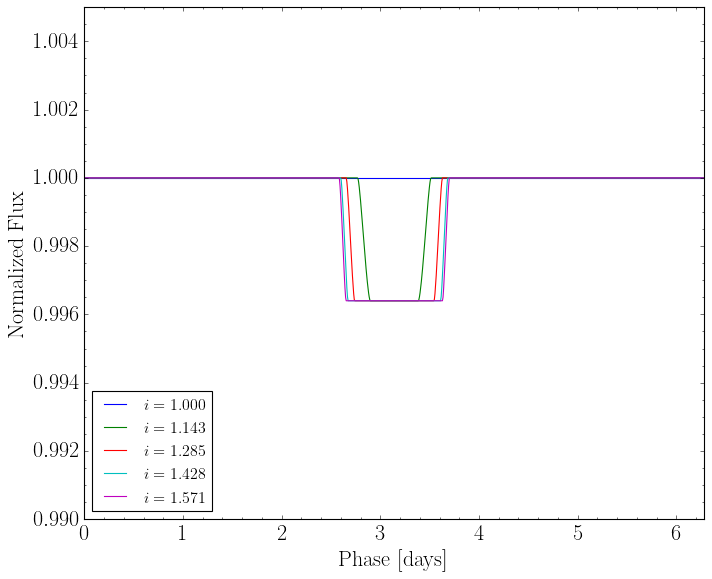

In [306]:
tarr = np.linspace(0, P, 1e3)

# k, a, i, t0, P = .05, .35, math.pi/3, 1, 2*math.pi

plt.figure(figsize=[10,8])
for i in np.linspace(1,math.pi/2,5):
    k = .06
    a = 2
    t0 = math.pi/2
    P = 2*math.pi
    model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    plt.plot(tarr, model_flux, label=r'$i=%.3f$'%(i))
plt.ylim(0.99,1.005)
plt.xlim(0,P)
plt.legend(loc=3)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

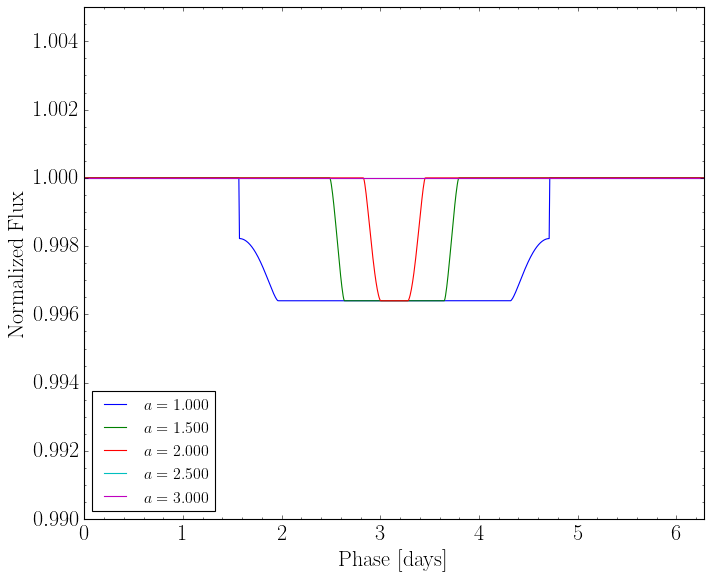

In [326]:
plt.figure(figsize=[10,8])
for a in np.linspace(1,3,5):
    k = .06
    i = 1.1
    t0 = math.pi/2
    P = 2*math.pi
    model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    plt.plot(tarr, model_flux, label=r'$a=%.3f$'%(a))
plt.ylim(0.99,1.005)
plt.xlim(0,P)
plt.legend(loc=3)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

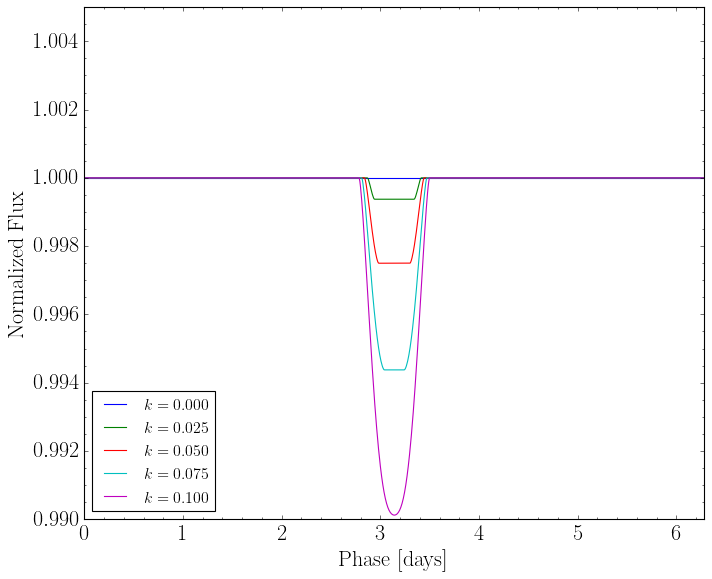

In [308]:
plt.figure(figsize=[10,8])
for k in np.linspace(0,.1,5):
    i = 1.1
    a = 2
    t0 = math.pi/2
    P = 2*math.pi
    model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    plt.plot(tarr, model_flux, label=r'$k=%.3f$'%(k))
plt.ylim(0.99,1.005)
plt.xlim(0,P)
plt.legend(loc=3)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

**Problem 3:** Use your model to fit the data ‘mystery_planet02.txt’. What is the
period? What is the depth, impact parameter, and duration of this
transiting body? What is the density of the star?

In [117]:
data = pd.read_csv('files/mystery_planet02.txt', delim_whitespace=True, header=None)

time, flux, flux_err = np.array(data[0]), np.array(data[1]), np.array(data[2])

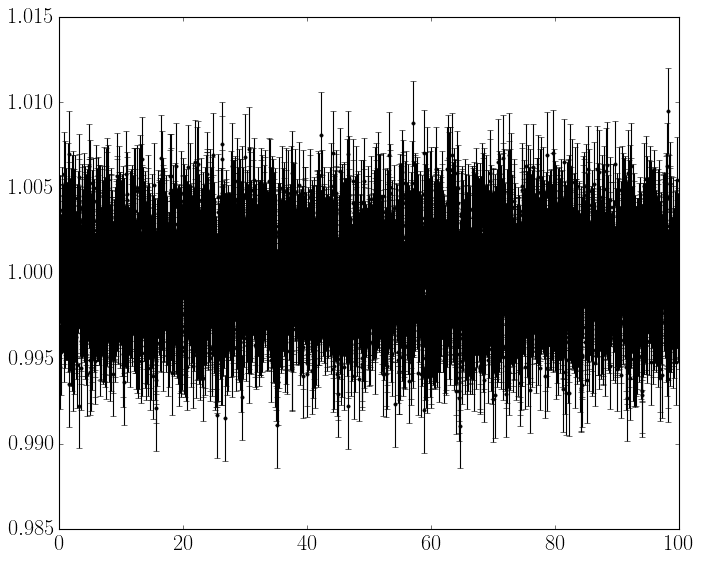

In [9]:
plt.figure(figsize=[10,8])
plt.errorbar(time, flux, yerr=flux_err, fmt='.', color='k')
plt.ticklabel_format(useOffset=False)
plt.show()

In [122]:
def phase_fold(time, flux, flux_err, P):
    
    fold = time % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_flux = flux[phase_sort]
    phase_flux_err = flux_err[phase_sort]
    
    return phase_time, phase_flux, phase_flux_err

In [400]:
model = BoxLeastSquares(time * u.day, flux, dy=flux_err)

periods = np.linspace(1, 50, 1e5) * u.day
periodogram = model.power(periods, 0.2)

best period: 9.793627936279362 d


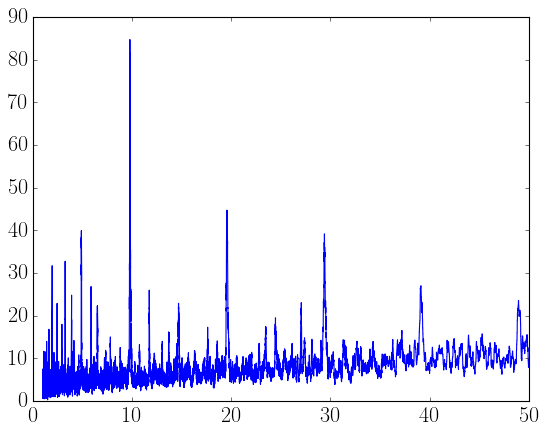

In [120]:
plt.plot(periodogram.period, periodogram.power);
print('best period:', periodogram.period[np.argmax(periodogram.power)])

In [380]:
def plot_lc_model(theta, data, P, **kwargs):
    """
    Plot light curve with parameters theta, compute chi^2
    and calculate other parameters of interest (b, delta, T, tau, rho)
    
    theta  : array of transit model parameters (k, a, i, t0)
    data   : phase folded data arrays (phase_time, phase_flux, phase_flux_err)
    P      : best fit period (using BLS)
    """
    k, a, i, t0 = theta
    phase_time, phase_flux, phase_flux_err = data
    
    # compute flux over one period to plot
    tarr = np.linspace(0, P, 1e3)
    plot_model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    
    # compute chi^2 of model with parameters given in theta
    model_flux = transitFlux(phase_time, k, a, i, t0, P, F0=1)
    chi_val = np.sum(((phase_flux - model_flux)/phase_flux_err)**2)
    
    # calculate other parameters of interest
    b     = a*np.cos(i)
    delta = k**2 
    T     = np.sqrt(1 - b**2)/(math.pi*a)*P
    tau   = k*T/(1 - b**2)
    rho   = 3/math.pi**2 * (P*24*3600)/(G*(T*24*3600)**3) * (1 - b**2)**(3/2)
    
    lbl = r'Model fit: $k=%.3f, a=%.3f, i=%.3f, t_0=%.3f, P=%.3f$'%(k, a, i, t0, P)
    lbl2 = r'$b=%.3f, \delta=%.4f, T=%.3f, \tau=%.3f, \rho=%.3f$'%(b, delta, T, tau, rho)
    
    # plot data and model
    plt.figure(figsize=[20,8])
    plt.errorbar(phase_time, phase_flux, yerr=phase_flux_err, fmt='.', color='k', elinewidth=.3)
    plt.plot(tarr, plot_model_flux, color='r', linewidth=2, label=r'$\chi^2=%.3f$'%(chi_val))
    plt.text(.15, 1.013, lbl, ha='left', fontsize=18)
    plt.text(.15, .987, lbl2, ha='left', va='top', fontsize=18)
    plt.xlim(0, P)
    plt.title('Transit Model Fit', fontsize=22)
    plt.xlabel('Phase [days]', fontsize=20)
    plt.ylabel(r'Normalized Flux', fontsize=20)
    plt.legend(loc='lower right')
    plt.ticklabel_format(useOffset=False)
    plt.minorticks_on()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()
    
    return b, delta, T, tau, rho

In [424]:
math.pi/2

1.5707963267948966

In [449]:
57.022e6/696340

81.88815808369475

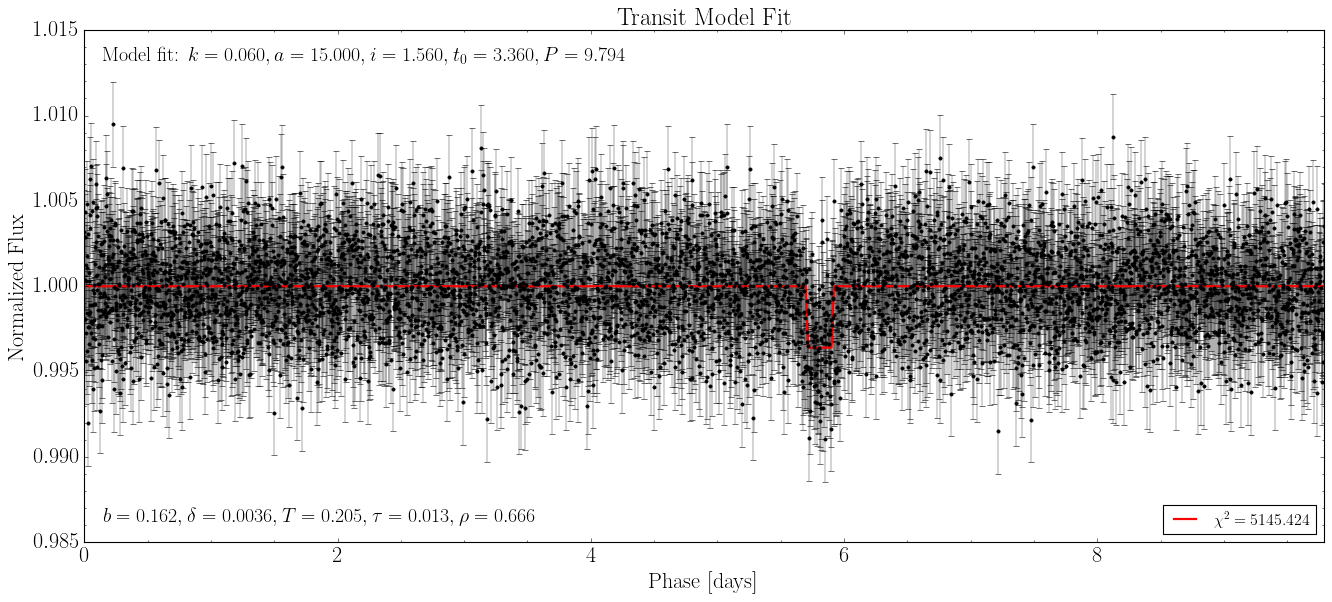

In [474]:
# k = .07
# i = 1.28
# a = 3.45
# t0 = 3.36
# P = best_period

k = .06
i = 1.56
a = 15
t0 = 3.36
P = best_period

theta = [k, a, i, t0]
data = phase_time, phase_flux, phase_flux_err

plot_lc_model(theta, data, P, save='transit_model_initial.png');

In [466]:
def log_likelihood(theta, data, P):
    """
    Assume Gaussian likelihood function
    theta : model parameters (k, a, i, t0, P)
    data  : phase-folded time, flux, flux_err
    P     : period, fixed during optimization
    """
    k, a, i, t0 = theta
    phase_time, phase_flux, phase_flux_err = data
    
    phase_flux_model = transitFlux(phase_time, k, a, i, t0, P)
    
    return -0.5 * np.sum((phase_flux - phase_flux_model)**2/phase_flux_err**2)


def log_prior(theta):
    """
    Assume uniform prior for all model parameters k, a, i, t0
    """
    k, a, i, t0 = theta
    if (bounds[0][0] < k < bounds[0][1]) & (bounds[1][0] < a < bounds[1][1]) \
        & (bounds[2][0] < i < bounds[2][1]) & (bounds[3][0] < t0 < bounds[3][1]) & (.1 < a*np.cos(i) < .2):
        return 0.0
    return -np.inf


def log_probability(theta, data, P):
    """
    Mulitply prior and likelihood
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data, P)

In [475]:
nlp = lambda *args: -log_probability(*args)

initial = [k, a, i, t0]
bounds  = [(0,1), (1,200), (0,math.pi/2), (0,P)]
data    = [phase_time, phase_flux, phase_flux_err]

soln = minimize(nlp, initial, method='nelder-mead', args=(data, P))

In [476]:
print(soln)
print('initial:', initial)

 final_simplex: (array([[ 0.05737968, 15.39718034,  1.56352452,  3.35428168],
       [ 0.05738058, 15.39724777,  1.56352478,  3.3542816 ],
       [ 0.05738014, 15.39725354,  1.56352469,  3.35428139],
       [ 0.05737969, 15.39727825,  1.56352466,  3.35428236],
       [ 0.0573805 , 15.39712546,  1.56352462,  3.35428129]]), array([2569.24145292, 2569.24145294, 2569.24145294, 2569.24145295,
       2569.24145298]))
           fun: 2569.2414529248117
       message: 'Optimization terminated successfully.'
          nfev: 452
           nit: 257
        status: 0
       success: True
             x: array([ 0.05737968, 15.39718034,  1.56352452,  3.35428168])
initial: [0.06, 15, 1.56, 3.36]


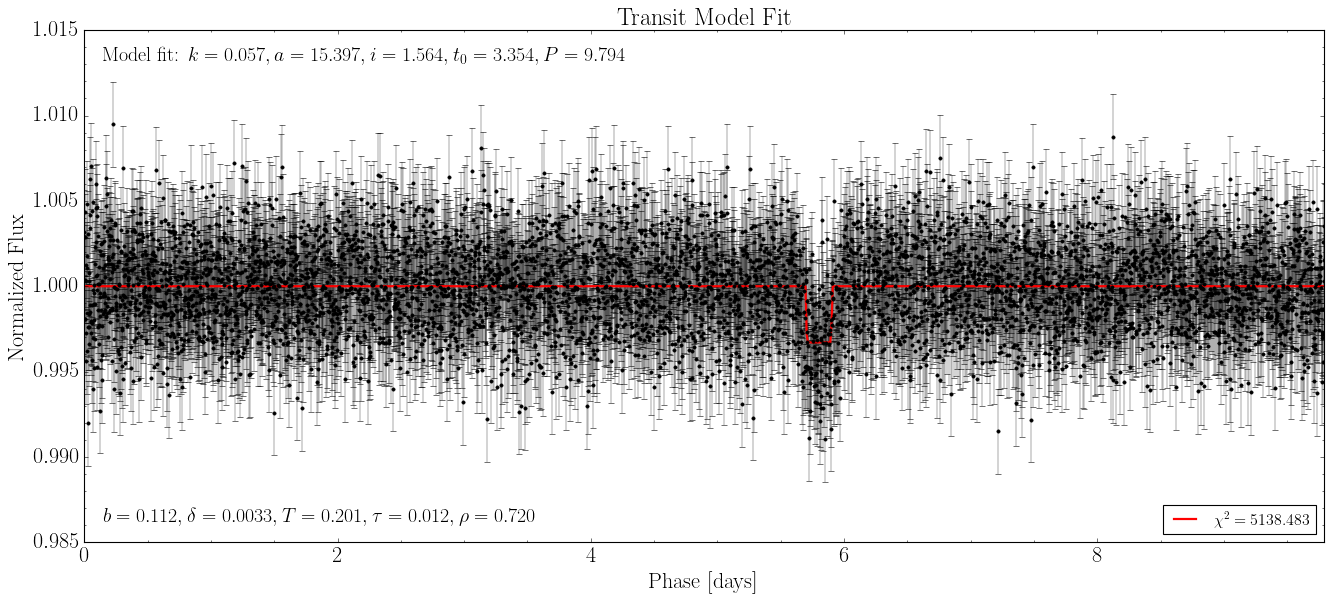

In [477]:
k_sol, a_sol, i_sol, t0_sol = soln.x
b_sol, delta_sol, T_sol, tau_sol, rho_sol = plot_lc_model(soln.x, data, best_period, save='transit_model_final.png')

In [386]:
pos = soln.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data, P))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [1:58:02<00:00,  1.42s/it]  


In [388]:
np.save('mcmc_run2', flat_samples)
# np.load('mcmc_run1.npy')

In [387]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

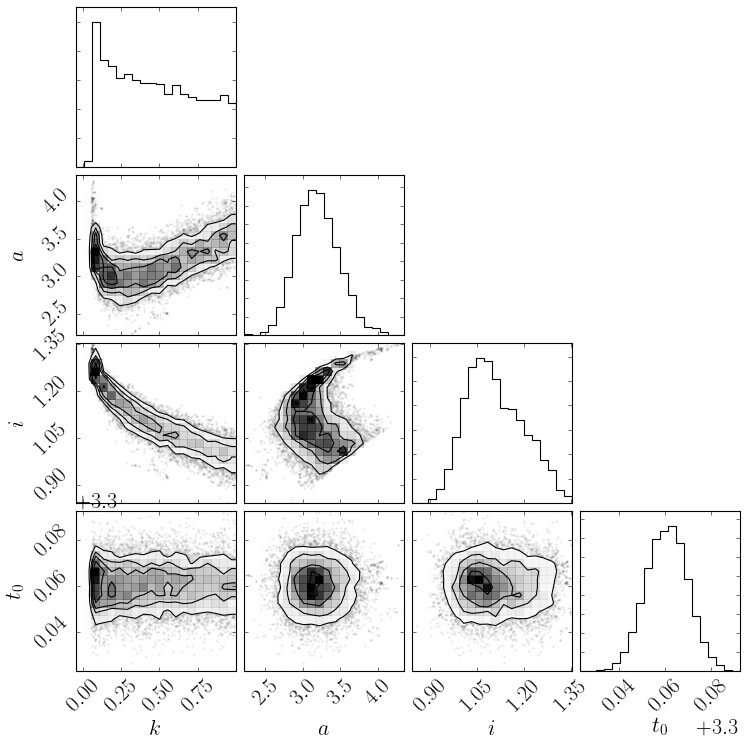

In [389]:
fig = corner.corner(flat_samples, labels=[r'$k$', r'$a$', r'$i$', r'$t_0$'], label_kwargs={'fontsize':20});
fig.savefig('posterior.png')

In [353]:
flat_samples

array([[0.63063255, 2.92043005, 0.99584026, 3.36457295],
       [0.64006449, 2.84413741, 0.97202896, 3.34302182],
       [0.84832806, 3.6124354 , 1.04752023, 3.3308825 ],
       ...,
       [0.24715037, 3.00961304, 1.16426548, 3.35985273],
       [0.83247291, 3.38660552, 1.0136607 , 3.35038809],
       [0.15353542, 3.23591791, 1.22805146, 3.34724412]])

In [411]:
b = flat_samples.T[1]*np.cos(flat_samples.T[2])

In [412]:
min(b)

0.893483097685343

In [410]:
len(flat_samples), len(flat_samples[b < .5])

(10432, 0)

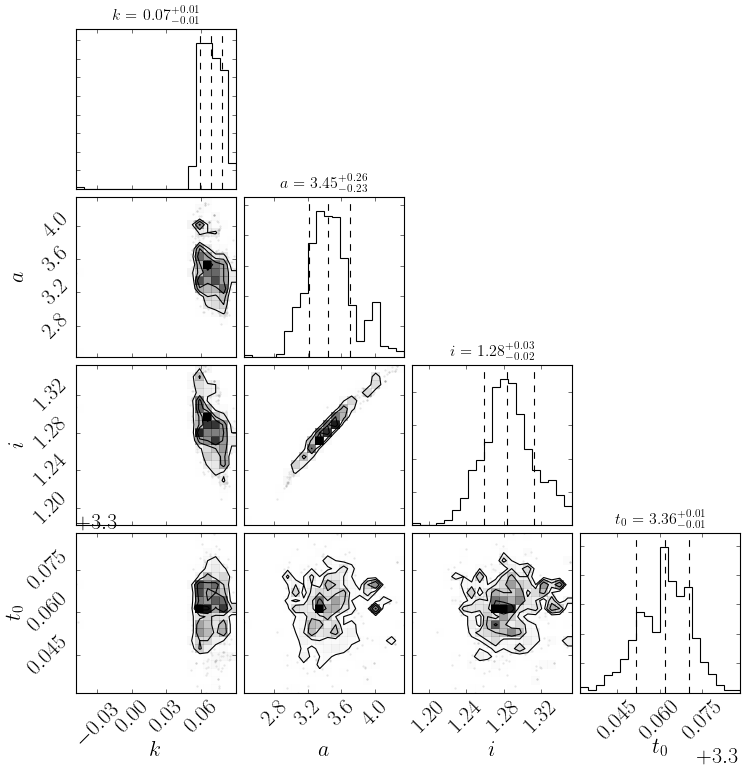

In [409]:
fig = corner.corner(flat_samples[b < 1], labels=[r'$k$', r'$a$', r'$i$', r'$t_0$'], label_kwargs={'fontsize':20}, \
             quantiles=[0.16, 0.5, 0.84], show_titles=True);
fig.savefig('posterior_b<1.png')

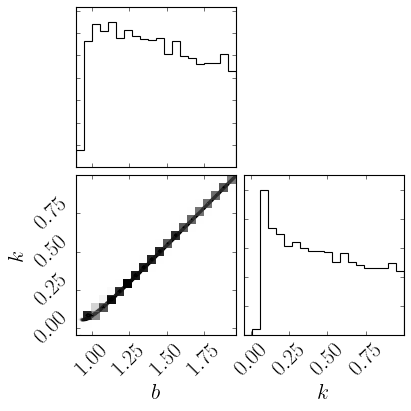

In [398]:
fig = corner.corner(np.vstack([b, flat_samples.T[0]]).T, labels=[r'$b$', r'$k$'], label_kwargs={'fontsize':20});
fig.savefig('b_k_posterior.png')

**Extra Credit:** find the probability distribution of parameters
assuming a circular orbit